In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 【問題1】2次元畳み込み層の作成

## 【問題2】2次元畳み込み後の出力サイズ

## 【問題3】最大プーリング層の作成

## 【問題4】平均プーリングの作成

## 【問題5】平滑化

In [2]:
class Scratch2dCNNClassifier():
    def __init__(self, initializer, optimizer, in_channel=1, out_channel=1, kernel=(1,1), stride=(1,1), padding=0, verbose=False):
        self.stride = stride    # tuple
        self.padding = padding  # int
        self.kernel = kernel    # tuple
        self.W = initializer.W(in_channel, out_channel, kernel[0], kernel[1])
        self.b = initializer.b(out_channel)
        self.optimizer = optimizer
        self.verbose = verbose
        self.Z = None

    def forward(self, X):
        #Xの次元は(batchsize, channel, height, width)
        self.X = X
        
        #outputのshapeは 0:in_channel, 1:out_channel, 2:out_height, 3:out_width
        self.batchsize, self.in_channel, self.in_h, self.in_w = X.shape
        self.out_channel = len(self.b)
        self.out_h = self._calc_hout()
        self.out_w = self._calc_wout()
        if not self.out_w.is_integer() or not self.out_h.is_integer():
            print('Check kernelsize, stride, padding')
            print(f'output shape: ({self.batchsize}, {self.out_channel}, {self.out_h}, {self.out_w})')
            return 
        else:
            self.out_h, self.out_w = int(self.out_h), int(self.out_w)
        if self.verbose:
            print(f'conv output shape: ({self.batchsize}, {self.out_channel}, {self.out_h}, {self.out_w})')
        
        if self.padding == 0:
            self.X_pad = self.X.copy()
        elif self.padding > 0:
            self.X_pad = np.zeros((self.batchsize, self.in_channel,
                                   self.in_h+2*self.padding, self.in_w+2*self.padding))
            self.X_pad[:,:,self.padding:-self.padding, self.padding:-self.padding] += self.X
        
        self.Z = np.zeros((self.batchsize, self.out_channel, self.out_h, self.out_w))
        sh, sw = self.stride
        kh, kw = self.kernel
        for b in range(self.batchsize):
            for o_ch in range(self.out_channel):
                for i_ch in range(self.in_channel):
                    for o_h in range(self.out_h):
                        for o_w in range(self.out_w):
                            self.Z[b,o_ch,o_h,o_w] += np.sum(self.X_pad[b,i_ch,sh*o_h:sh*o_h+kh,sw*o_w:sw*o_w+kw]*self.W[i_ch,o_ch])
                self.Z[b,o_ch] += self.b[o_ch]
            
        return self.Z

    def backward(self, dA):
        self, dA = self.optimizer.update(self, dA)
        return dA
    
    def _calc_hout(self):
        return (self.in_h+2*self.padding-self.kernel[0])/self.stride[0] + 1
    
    def _calc_wout(self):
        return (self.in_w+2*self.padding-self.kernel[1])/self.stride[1] + 1

In [3]:
def calc_size(n, pad, kernel, stride):
    return (n+2*pad-kernel)/stride + 1


class MaxPool2D():
    def __init__(self, pool_size=(2,2), stride=(2,2), verbose=False):
        self.pool_size = pool_size
        self.stride = stride
        self.verbose = verbose
    
    def forward(self, X):
        self.X = X
        batchsize, channel, h, w = X.shape
        h_out = calc_size(h, 0, self.pool_size[0], self.stride[0])
        w_out = calc_size(w, 0, self.pool_size[1], self.stride[1])
        if not h_out.is_integer() or not w_out.is_integer():
            print('Check pool_size and stride')
            print(f'output shape: ({batchsize}, {channel}, {h_out}, {w_out})')
            return 
        else:
            h_out, w_out = int(h_out), int(w_out)
        if self.verbose:
            print(f'pooling output shape: ({batchsize}, {channel}, {h_out}, {w_out})')
        
        self.Z = np.zeros((batchsize, channel, h_out, w_out))
        self.idx = []
#         self.idx = np.zeros_like(X)
        h_p, w_p = self.pool_size
        h_str, w_str = self.stride
        for b in range(batchsize):
            for ch in range(channel):
                for i in range(h_out):
                    for j in range(w_out):
                        tmp = np.argmax(X[b,ch,h_str*i:h_str*(i+1),w_str*j:w_str*(j+1)])
#                         self.idx.append(tmp)
                        row = h_str*i + tmp//h_p
                        col = w_str*j + tmp%w_p
                        self.idx.append((row, col))
                        self.Z[b,ch,i,j] = np.max(X[b,ch,h_str*i:h_str*i+h_p,w_str*j:w_str*j+w_p])
        return self.Z
        
    def backward(self, dA):
        delta = np.zeros_like(self.X)
        batchsize, channel, h, w = dA.shape
        dA = dA.reshape(batchsize, channel, -1)
        for b in range(batchsize):
            for ch in range(channel):
                for idx, loss in zip(self.idx, dA[b,ch]):
                    delta[b,ch,idx[0],idx[1]] += loss
        return delta

In [4]:
class MeanPool2D():

    def __init__(self, pool_size=(2,2), stride=(2,2), verbose=False):
        self.pool_size = pool_size
        self.stride = stride
        self.verbose = verbose
    
    def forward(self, X):
        self.X = X
        batchsize, channel, h, w = X.shape
        h_out = calc_size(h, 0, self.pool_size[0], self.stride[0])
        w_out = calc_size(w, 0, self.pool_size[1], self.stride[1])
        if not h_out.is_integer() or not w_out.is_integer():
            print('Check pool_size and stride')
            print(f'output shape: ({batchsize}, {channel}, {h_out}, {w_out})')
            return 
        else:
            h_out, w_out = int(h_out), int(w_out)
            self.h_out, self.w_out = h_out, w_out
        if self.verbose:
            print(f'pooling output shape: ({batchsize}, {channel}, {h_out}, {w_out})')
      
        self.Z = np.zeros((batchsize, channel, h_out, w_out))
#         self.loss_coef = []
        h_p, w_p = self.pool_size
        h_str, w_str = self.stride
        for b in range(batchsize):
            for ch in range(channel):
                for i in range(h_out):
                    for j in range(w_out):
#                         self.loss_coef = idx[b,ch,h_str*i:h_str*(i+1),w_str*j:w_str*(j+1)] = 1 / (h_p*w_p)
                        self.Z[b,ch,i,j] = np.mean(X[b,ch,h_str*i:h_str*i+h_p,w_str*j:w_str*j+w_p])
        return self.Z
        
    def backward(self, dA):
        loss = np.zeros_like(self.X)
        h_str, w_str = self.stride
        h_p, w_p = self.pool_size
        for b in range(dA.shape[0]):
            for ch in range(dA.shape[1]):
                for h in range(self.h_out):
                    for w in range(self.w_out):
                         loss[b,ch,h_str*h:h_str*h+h_p,w_str*w+w_p] += dA[b,ch,h,w]
        return loss / (h_p*w_p)

In [5]:
class Flatten():
    def __init__(self):
        pass
    
    def forward(self, X):
        self.b, self.ch, self.h, self.w = X.shape
        return X.reshape(-1, self.ch*self.h*self.w)
    
    def backward(self, dA):
        return dA.reshape(self.b, self.ch, self.h, self.w)

In [6]:
class ConvInitializer:
    def __init__(self, sigma=1):
        self.sigma = sigma
        
    def W(self, inchannel, outchannel, kh, kw):
        return np.random.randn(inchannel, outchannel, kh, kw)
    
    def b(self, outchannel):
        return np.random.randn(outchannel)

In [7]:
class ConvSGD:
    def __init__(self, lr=0.001):
        self.lr = lr
        
    def update(self, layer, dA):
        db = np.zeros(layer.out_channel)
        for o_ch in range(layer.out_channel):
            db[o_ch] = np.sum(dA[:,o_ch,:,:])
            
        dW = np.zeros_like(layer.W)
        for b in range(layer.batchsize):
            for i_ch in range(layer.in_channel):
                for o_ch in range(layer.out_channel):
                    for h in range(layer.kernel[0]):
                        for w in range(layer.kernel[1]):
                            dW[i_ch,o_ch,h,w] = np.sum(layer.X_pad[b,i_ch,h:h+layer.out_h,w:w+layer.out_w]*dA[b,o_ch])
                            
        dX = np.zeros_like(layer.X)
        for b in range(layer.batchsize):
            for i_ch in range(layer.in_channel):
                for o_ch in range(layer.out_channel):
                    for h in range(layer.out_h-layer.kernel[0]):
                        for w in range(layer.out_w-layer.kernel[1]):
                            dX[b,i_ch,h:h+layer.kernel[0],w:w+layer.kernel[1]] += layer.W[i_ch,o_ch] * dA[b,o_ch,h,w]
        
        layer.b -= self.lr * db
        layer.W -= self.lr * dW
        self.dX = dX
        self.dW = dW
        return layer, dX

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from tqdm import tqdm

Using TensorFlow backend.


In [9]:
class FC():
    def __init__(self, n_nodes1, n_nodes2, activator, initializer, optimizer):
        self.optimizer = optimizer
        self.activator = activator
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):  
        self.X = X
        self.n_batch = len(self.X)
        self.Z = np.dot(X, self.W) + self.B
        self.A = self.activator.forward(self.Z)
        return self.A    

    def backward(self, dA):
        dZ = self.activator.backward(dA)
        self, dA = self.optimizer.update(self, dZ)
        return dA
    
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        return np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return np.random.randn(n_nodes2)

class HeInitializer():
    def __init__(self):
        self.std = None
    
    def W(self, n_nodes1, n_nodes2):
        self.std = np.sqrt(n_nodes1/2)
        return np.random.randn(n_nodes1, n_nodes2) / self.std
    
    def B(self, n_nodes2):
        return np.random.randn(n_nodes2) / self.std
    
    
class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dZ):
        dB = np.sum(dZ, axis=0)
        dW = np.dot(layer.X.T, dZ)
        dA = np.dot(dZ, layer.W.T)
        layer.B -= self.lr * dB / layer.n_batch
        layer.W -= self.lr * dW / layer.n_batch
        return layer, dA

class Relu():
    def __init__(self):
        pass
    
    def forward(self, Z):
        self.A = np.maximum(0, Z)
        return self.A
    
    def backward(self, dA):
        return  dA * np.where(self.A>0, 1, 0)
    
class Softmax():
    def __init__(self):
        pass
    
    def forward(self, Z):
        if Z.ndim == 2:
            Z = Z.T
            self.A = (np.exp(Z) / np.sum(np.exp(Z), axis=0)).T
            return self.A
        self.A = np.exp(Z) / np.sum(np.exp(Z))
        return self.A
    
    def backward(self, y):
        return self.A - y

class ScratchDeepNeuralNetworkClassifier():
    def __init__(self, *layers, epoch=3):
        self.epoch = epoch
        self.n_layers = len(layers)
        self.layers = layers
        self.loss_train = []
        self.loss_valid = []

    def train(self, X, y, X_val=None, y_val=None):
        get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=5)
        for _ in tqdm(range(self.epoch)):
            for mini_X_train, mini_y_train in get_mini_batch:
                fout = mini_X_train.copy()
                for layer in self.layers:
                    fout = layer.forward(fout)

                bout = mini_y_train.copy()
                for layer in self.layers[::-1]:
                    bout = layer.backward(bout)
                    
            self.loss_train.append(self.crossentropy(mini_y_train, fout))
            if X_val is not None:
                y_val_pred = X_val.copy()
                for layer in self.layers:
                    y_val_pred = layer.forward(y_val_pred)
                self.loss_valid.append(self.crossentropy(y_val, y_val_pred))
        
        
    def crossentropy(self, y, y_pred):
        loss = -np.mean(np.sum(y*np.log(y_pred), axis=1))
        return loss
    
            
    def predict(self, X_test):
        out = X_test
        for layer in self.layers:
            out = layer.forward(out)
        return out

In [10]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 1, 28, 28)[:5000]
y_train = y_train[:5000]
X_train = X_train.astype(np.float)
X_train /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

## 【問題6】学習と推定

In [12]:
softmax = Softmax()
initializer1 = ConvInitializer()
optimizer1 = ConvSGD(lr=0.005)
initializer2 = SimpleInitializer(sigma=1)
optimizer2 = SGD(lr=0.005)

conv = Scratch2dCNNClassifier(initializer1, optimizer1, in_channel=1, out_channel=1, kernel=(3,3), stride=(1,1), padding=1)
mp = MaxPool2D(pool_size=(2,2), stride=(2,2))
fl = Flatten()
fc = FC(196, 10, softmax, initializer2, optimizer2)

nn = ScratchDeepNeuralNetworkClassifier(conv, mp, fl, fc, epoch=15)
nn.train(X_train, y_train, X_val, y_val)

100%|██████████| 15/15 [17:29<00:00, 69.94s/it]


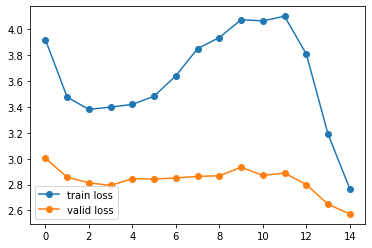

In [13]:
plt.plot(nn.loss_train, '-o', label='train loss')
plt.plot(nn.loss_valid, '-o', label='valid loss')
plt.legend()

In [14]:
y_pred = nn.predict(X_val)
accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_val, axis=1))

0.389

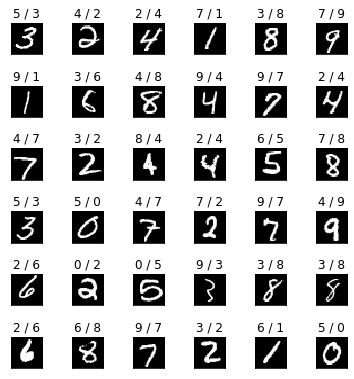

In [15]:
import pandas as pd
num = 36 # いくつ表示するか
#true_false = pd.get_dummies(y_pred).values==y_val
true_false = np.argmax(y_pred, axis=1)==np.argmax(y_val, axis=1)
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(np.argmax(y_pred[false_list[i]]),np.argmax(y_val[false_list[i]])))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

## 【問題7】LeNet

In [16]:
softmax = Softmax()
relu3 = Relu()
relu4 = Relu()
initializer1 = ConvInitializer()
optimizer1 = ConvSGD(lr=0.001)
initializer2 = HeInitializer()
optimizer2 = SGD(lr=0.001)
optimizer3 = SGD(lr=0.001)
optimizer4 = SGD(lr=0.001)

conv1 = Scratch2dCNNClassifier(initializer1, optimizer1, in_channel=1, out_channel=6,
                               kernel=(5,5), stride=(1,1), padding=0)
relu1 = Relu()
mp1 = MaxPool2D(pool_size=(2,2), stride=(2,2))
conv2 = Scratch2dCNNClassifier(initializer1, optimizer1, in_channel=6, out_channel=16,
                               kernel=(5,5), stride=(1,1), padding=0)
relu2 = Relu()
mp2 = MaxPool2D(pool_size=(2,2), stride=(2,2))
fl = Flatten()
fc1 = FC(256, 120, relu3, initializer2, optimizer2)
fc2 = FC(120, 84, relu4, initializer2, optimizer3)
fc3 = FC(84, 10, softmax, initializer2, optimizer4)

nn = ScratchDeepNeuralNetworkClassifier(conv1, relu1, mp1, conv2, relu2, mp2, fl, fc1, fc2, fc3, epoch=15)
nn.train(X_train, y_train, X_val, y_val)

100%|██████████| 15/15 [2:59:39<00:00, 718.64s/it] 


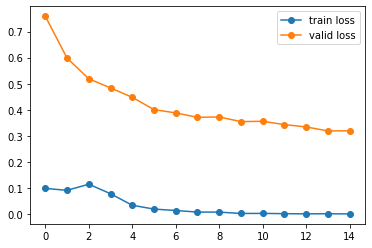

In [17]:
plt.plot(nn.loss_train, '-o', label='train loss')
plt.plot(nn.loss_valid, '-o', label='valid loss')
plt.legend()

In [18]:
y_pred = nn.predict(X_val)
accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_val, axis=1))

0.917

## 【問題9】出力サイズとパラメータ数の計算

- 入力サイズ：144x144, 3チャネル
- フィルタサイズ：3x3, 6チャネル
- ストライド：1
- パディング：なし
<br>  
出力サイズ：6x142x142  
パラメータ数：3\*3\*3\*6=162

- 入力サイズ：60x60, 24チャネル
- フィルタサイズ：3x3, 48チャネル
- ストライド：1
- パディング：なし
<br>  
出力サイズ：48x58x58  
パラメータ数：3\*3\*24\*48=10368

- 入力サイズ：20x20, 10チャネル
- フィルタサイズ：3x3, 20チャネル
- ストライド：2
- パディング：なし
<br>  
出力サイズ：20x9x9  
パラメータ数：3\*3\*10\*20=1800